In [1]:
import networkit as nk
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import ndlib.models.CompositeModel as gc
#import ndlib.models.compartments as nc

from bokeh.io import output_notebook, show
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

#NK and GT don't have methods to read adjacency lists.

#Size of graph is currently: 1.2m nodes, 8.7m edges
#Method 1 - Import GML into NK, then create NX graph (29s)
#gmlReader = nk.graphio.GMLGraphReader()
#G = gmlReader.read("dataset.gml")
#print(G.numberOfNodes())
#print(G.numberOfEdges())

#graph = nx.Graph()

#print("Adding nodes...")
#for i in G.iterNodes():
#    graph.add_node(i)

#print("Adding edges...")
#for i in G.iterEdges():
#    graph.add_edge(i[0],i[1])

#del(G)
#print(len(graph.nodes()))
#print(len(graph.edges()))

#Method 2 - Read adjacency list into NX (37s)
#G = nx.read_adjlist('dataset.adjlist')
#print(len(G.nodes()))
#print(len(G.edges()))

#Method 3 - Read GML into GT (1m)
#graph = gt.load_graph("dataset.gml")
#print(len(graph.get_vertices()))
#print(len(graph.get_edges()))

#Method 4 - Read GML into NX (8.30m)
#G = nx.read_gml('dataset.gml', label='id')
#relabeled = nx.convert_node_labels_to_integers(G)
#del(G)
#print(len(relabeled.nodes()))
#print(len(relabeled.edges()))

#Method 5 - Read Pickle into NX ()
G = nx.read_gpickle('Datasets/dataset.gpickle')
relabeled = nx.convert_node_labels_to_integers(G)
del(G)
print(len(relabeled.nodes()))
print(len(relabeled.edges()))

1230324
8744807


In [5]:
for i in nx.get_edge_attributes(relabeled,'weight'):
    print(relabeled.edges[i]['weight'])
    break;
print(relabeled.nodes[0])

0.27833572122331574
{'age': '65+', 'family_id': 1}


In [ ]:
#STANDARD SEIR MODEL SIMULATION
print("Simulating...")
# Model selection
model = ep.SEIRModel(relabeled)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.57)
cfg.add_model_parameter('gamma', 0.15)
cfg.add_model_parameter('alpha', 0.2)
cfg.add_model_parameter("fraction_infected", 0.05)
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(10,progress_bar=True)
trends = model.build_trends(iterations)

In [6]:
#CUSTOM SEIR_AS MODEL SIMULATION
print("Simulating...")
from ndlibCustom.SEIR_ASModel import SEIR_ASModel
# Model selection
model = SEIR_ASModel(relabeled)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.57) #Infection rate from I_A/S Neighbors
cfg.add_model_parameter('gamma', 0.15) #Recovery/Removal rate
cfg.add_model_parameter('alpha', 0.2) #Latent period
cfg.add_model_parameter('kappa', 0.25) #Symptomatic/Asymptomatic Ratio

#This parameter "smoothens" out the infection rate in the first iterations.
#1: 1-(1-beta)^(num_of_infected_neighbors)[0.99 on > 5 infected neighbors]
#2: beta*(average_infected_weight)
cfg.add_model_parameter('tp_rate', 0) #Infection rate does not depend on neighbour sample size


cfg.add_model_parameter("fraction_infected", 0.005) #Starting infected nodes
model.set_initial_status(cfg)

# Simulation execution
#iteration = model.iteration()
iterations = model.iteration_bunch(50,progress_bar=True)
trends = model.build_trends(iterations)

  0%|          | 0/50 [00:00<?, ?it/s]

Simulating...


100%|██████████| 50/50 [03:43<00:00,  4.47s/it]


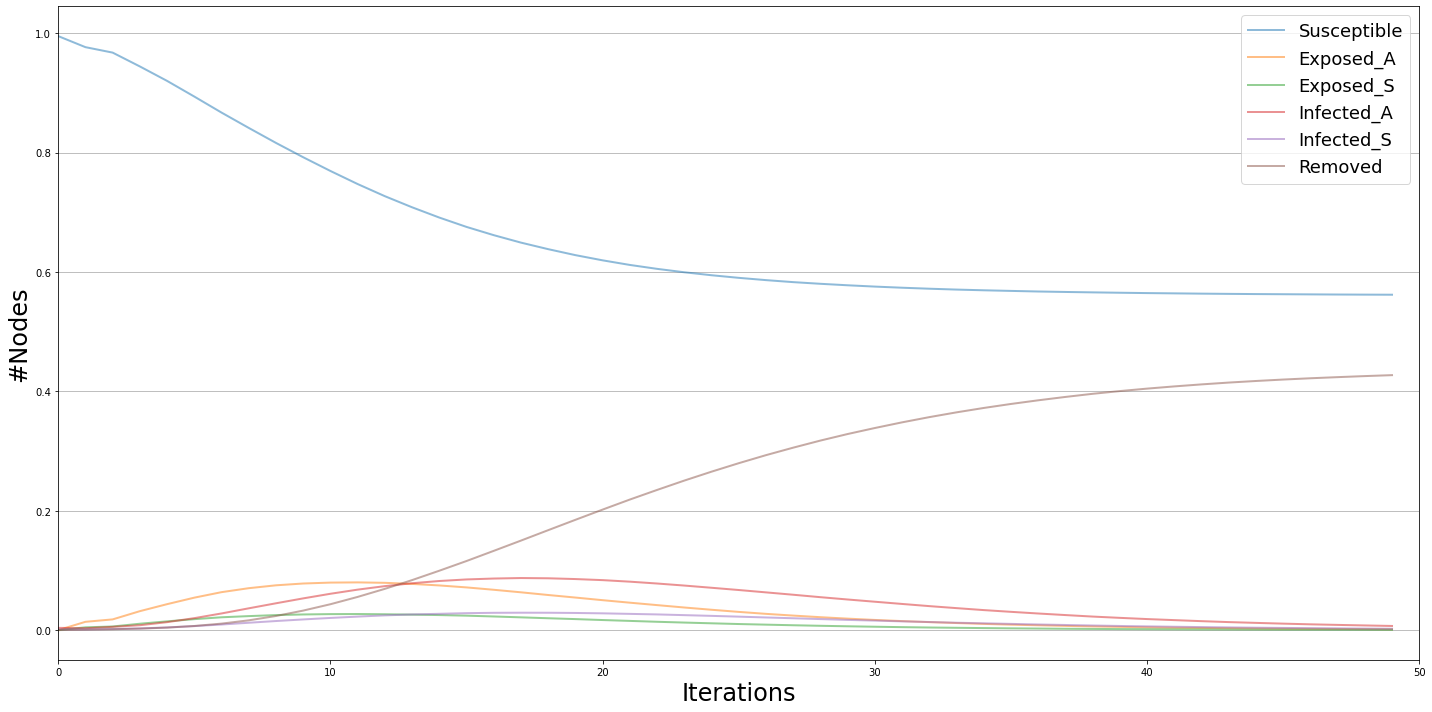

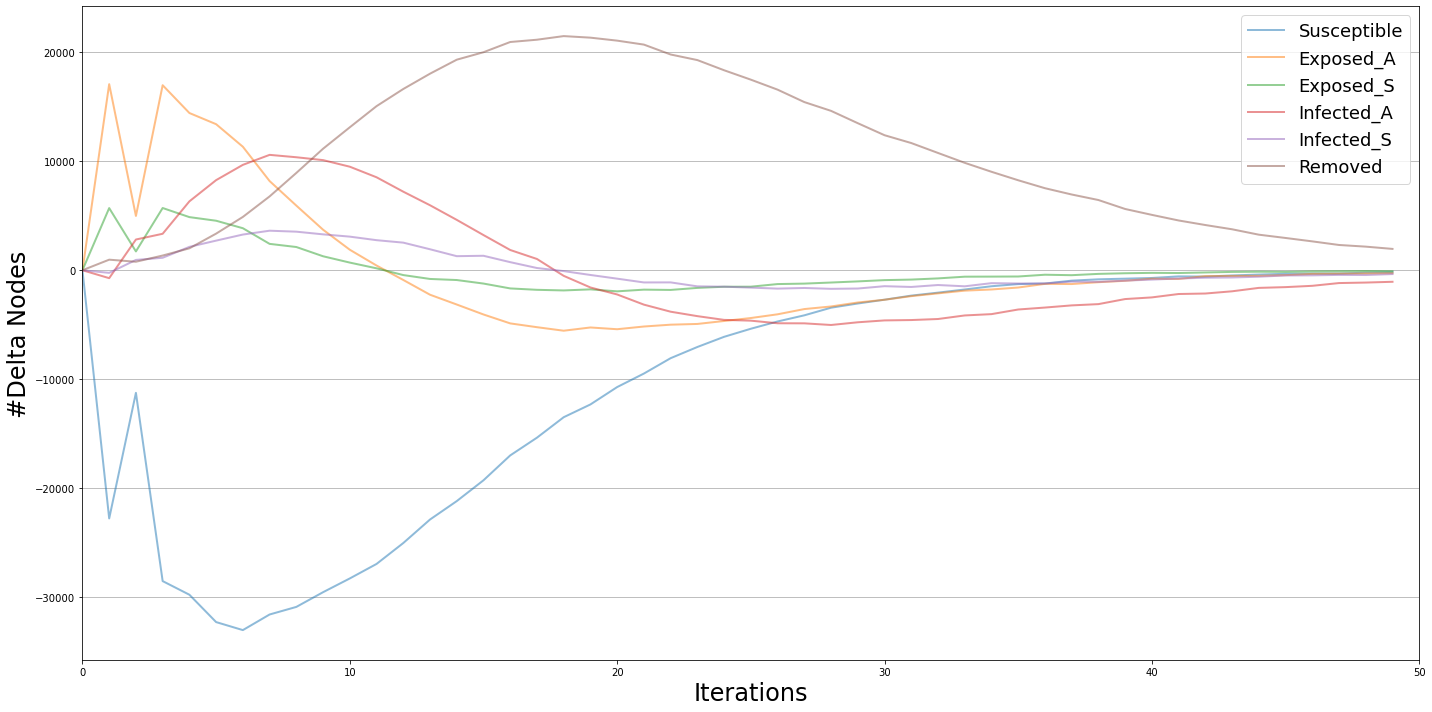

In [7]:
viz = DiffusionTrend(model, trends)
p = viz.plot()

viz2 = DiffusionPrevalence(model, trends)
p2 = viz2.plot()

Text(0, 0.5, 'ECCDF')

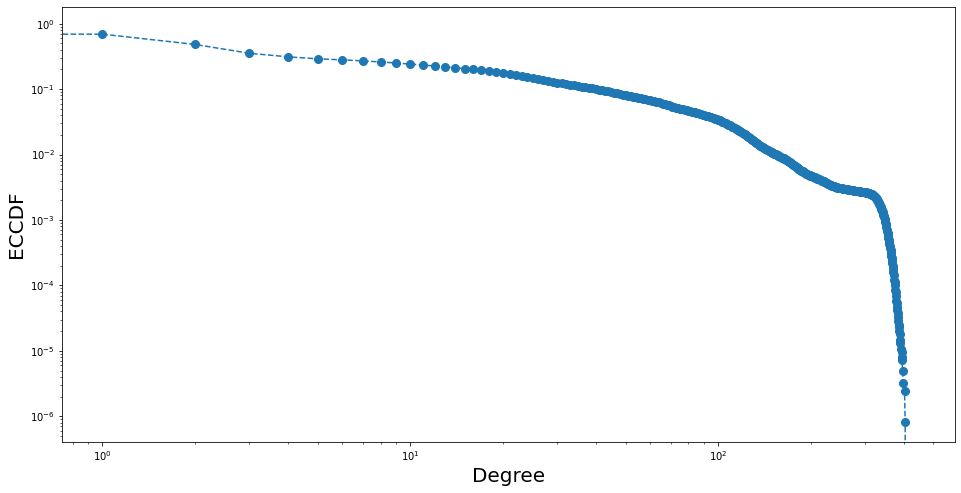

In [40]:
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

density = nx.density(relabeled)
degree = list(dict(relabeled.degree()).values())
#ECCDF in loglog scale
cdf = ECDF(degree)
x = np.unique(degree)
y = cdf(x)
fig_cdf = plt.figure(figsize=(16,8))
axes = fig_cdf.gca()
axes.loglog(x,1-y,marker='o',ms=8, linestyle='--')
axes.set_xlabel('Degree',size=20)
axes.set_ylabel('ECCDF', size=20)

In [39]:
#Create complete status map by dymanically rebuilding infection iteration results
#Keys are nodes, values are final statuses
#Look for keys in graph to get attributes

graph_stat = {}
for i in relabeled.nodes():
    graph_stat[i] = 0
for iter in iterations:
    for s in iter['status']:
        graph_stat[s] = iter['status'][s]    

In [41]:
stats_giovani = {0:[],1:[],2:[],3:[],4:[],5:[]}
stats_attivi = {0:[],1:[],2:[],3:[],4:[],5:[]}
stats_anziani = {0:[],1:[],2:[],3:[],4:[],5:[]}
for i in graph_stat:
    if relabeled.nodes[i]['age'] == '65+':
        stats_anziani[graph_stat[i]].append(i)
    elif relabeled.nodes[i]['age'] == '20-64':
        stats_attivi[graph_stat[i]].append(i)
    else:
        stats_giovani[graph_stat[i]].append(i)
        
giovani_p = []
attivi_p = []
anziani_p = []
for i in stats_giovani:
    giovani_p.append(len(stats_giovani[i]))
    attivi_p.append(len(stats_attivi[i]))
    anziani_p.append(len(stats_anziani[i]))    

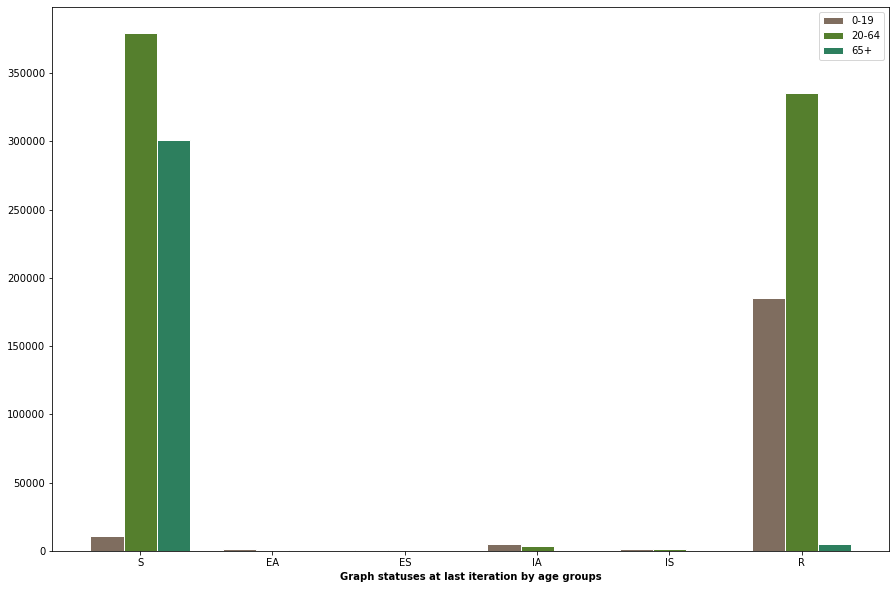

In [67]:
plt.rcParams['figure.figsize'] = [15, 10]
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = [12, 30, 1, 8, 22]
bars2 = [28, 6, 16, 5, 10]
bars3 = [29, 3, 24, 25, 17]
 
# Set position of bar on X axis
r1 = np.arange(len(giovani_p))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, giovani_p, color='#7f6d5f', width=barWidth, edgecolor='white', label='0-19')
plt.bar(r2, attivi_p, color='#557f2d', width=barWidth, edgecolor='white', label='20-64')
plt.bar(r3, anziani_p, color='#2d7f5e', width=barWidth, edgecolor='white', label='65+')

# Add xticks on the middle of the group bars
plt.xlabel('Graph statuses at last iteration by age groups', fontweight='bold')
labels = ['S', 'EA', 'ES', 'IA', 'IS',"R"]
plt.xticks([r + barWidth for r in range(len(giovani_p))], labels)
 
# Create legend & Show graphic
plt.legend()
plt.show()

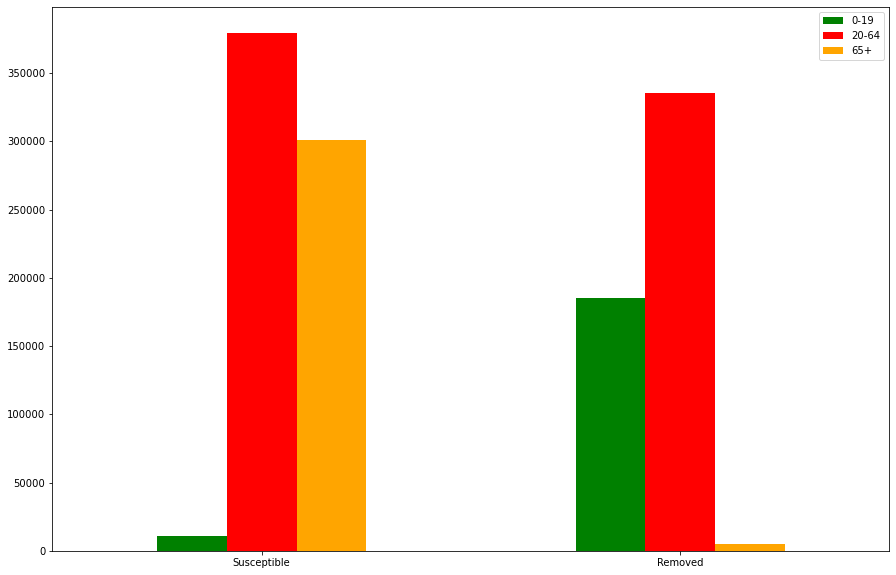

In [68]:
c1 = [giovani_p[0],giovani_p[5]]
c2 = [attivi_p[0], attivi_p[5]]
c3 = [anziani_p[0], anziani_p[5]]

index = ['Susceptible', 'Removed']
df = pd.DataFrame({'0-19': c1, '20-64': c2, '65+': c3}, index=index)
ax = df.plot.bar(rot=0, color={"0-19": "green", "20-64": "red", "65+":"orange"})